In [100]:
import numpy as np
from qiskit import QuantumCircuit, Aer, transpile, QuantumRegister, ClassicalRegister
from math import gcd
from fractions import Fraction
from qiskit.quantum_info import Operator
from qiskit.extensions import UnitaryGate
from qiskit.circuit.library import QFT

from qiskit.quantum_info import DensityMatrix, partial_trace, hellinger_fidelity
from qiskit.visualization import plot_histogram

Task 1: N qubits should provide phase precision down to $\pi * (1/2)^N$.

Task 2:
$$
U = \begin{bmatrix}
0 & -i \\
i & 0 \\
\end{bmatrix}$$

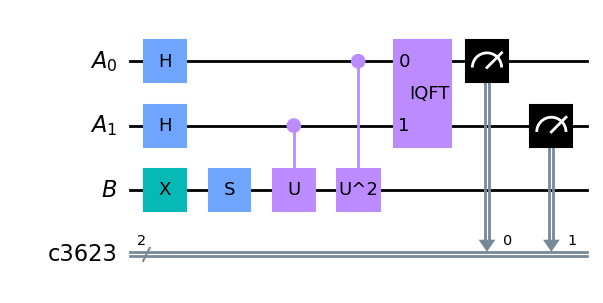

In [101]:
qr_ctrl = QuantumRegister(2, name="A")
qr_target = QuantumRegister(1, name="B")
cr_ctrl = ClassicalRegister(2)
qc = QuantumCircuit(qr_ctrl, qr_target, cr_ctrl)

for q in range(2):
    qc.h(q)
qc.x(2)
qc.s(2)

U = UnitaryGate([[0, -1j], [1j, 0]], label="U").control()
qc.append(U, [1, 2])
U2 = UnitaryGate([[1, 0], [0, 1]], label="U^2").control()
qc.append(U2, [0, 2])

qc.append(QFT(num_qubits=2).inverse(), [0, 1])
qc.measure([0, 1], [0, 1])

qc.draw("mpl")

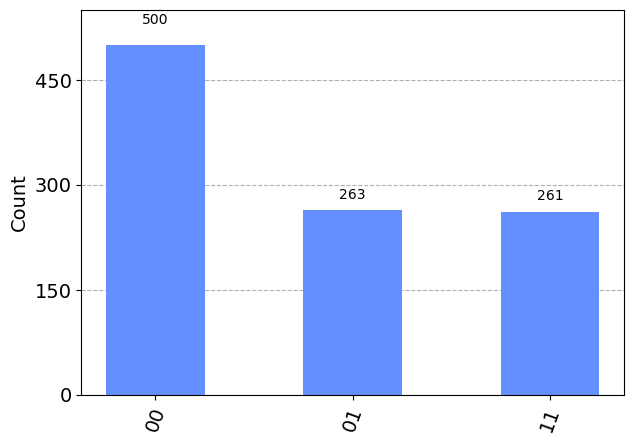

In [102]:
aer_sim = Aer.get_backend('aer_simulator')
job = aer_sim.run(transpile(qc, aer_sim), shots=1024, memory=True)
counts = job.result().get_counts()
plot_histogram(counts)

Phases are 0, 1/4 and 3/4. No Phase 2/4 measured. Does this mean Eigenvalues are +/- 1?

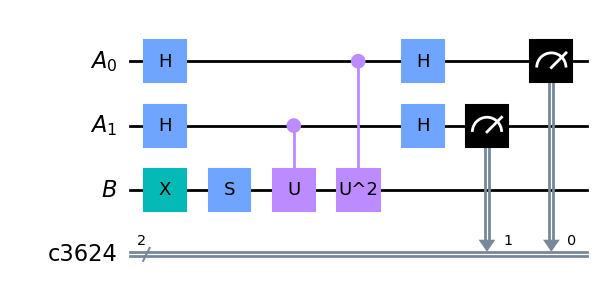

In [103]:
qr_ctrl = QuantumRegister(2, name="A")
qr_target = QuantumRegister(1, name="B")
cr_ctrl = ClassicalRegister(2)
qc = QuantumCircuit(qr_ctrl, qr_target, cr_ctrl)

for q in range(2):
    qc.h(q)
qc.x(2)
qc.s(2)

U = UnitaryGate([[0, -1j], [1j, 0]], label="U").control()
qc.append(U, [1, 2])
U2 = UnitaryGate([[1, 0], [0, 1]], label="U^2").control()
qc.append(U2, [0, 2])

# qc.append(QFT(num_qubits=2).inverse(), [0, 1])
for q in range(2):
    qc.h(q)
qc.measure([0, 1], [0, 1])

qc.draw("mpl")

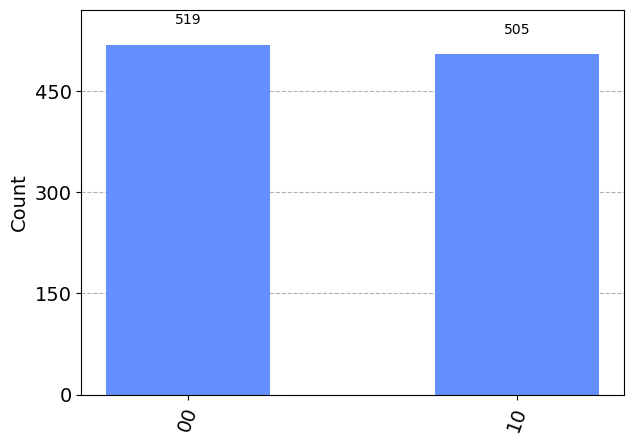

In [104]:
aer_sim = Aer.get_backend('aer_simulator')
job = aer_sim.run(transpile(qc, aer_sim), shots=1024, memory=True)
counts = job.result().get_counts()
plot_histogram(counts)

Using Hadamards instead oh inverse QFT does not provide the same result.

Task 3: If the phase doesn't neatly fit into a sequence of bits, the measured result will not be exact.

Task 4: Create QPE circuit for n qubits in the top register:

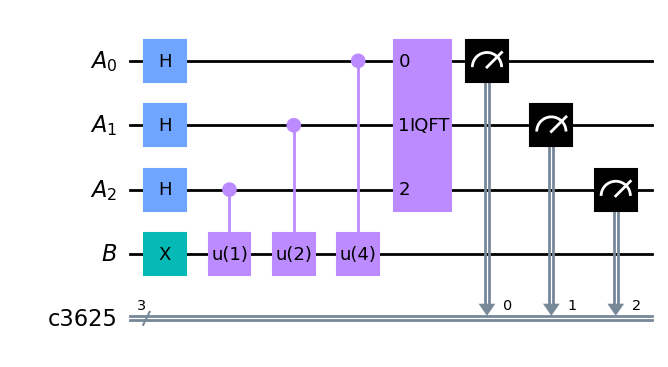

In [105]:
def QPE_pi(n):
    qr_ctrl = QuantumRegister(n, name="A")
    qr_target = QuantumRegister(1, name="B")
    cr_ctrl = ClassicalRegister(n)
    qc = QuantumCircuit(qr_ctrl, qr_target, cr_ctrl)

    for q in range(n):
        qc.h(q)
    qc.x(n)

    U = lambda theta: UnitaryGate([[1, 0], [0, np.cos(theta) + np.sin(theta)*1j]], label=f"u({theta})").control()

    theta = 1
    for q in range(n):
        # what is theta???
        qc.append(U(theta*2**q), [n-q-1, n])

    qc.append(QFT(num_qubits=n).inverse(), range(n))
    qc.measure(range(n), range(n))
    return qc

QPE_pi(3).draw("mpl")

Get the phase from the simulated reading:

In [106]:
aer_sim = Aer.get_backend('aer_simulator')
def phase(n, shots=1):
    qc = QPE_pi(n)
    # Simulate Results
    # `memory=True` tells the backend to save each measurement in a list
    job = aer_sim.run(transpile(qc, aer_sim), shots=shots, memory=True)
    readings = job.result().get_memory()
    # counts = job.result().get_counts()
    # print("Register Reading: " + readings[0])
    phase = [int(readings[k], 2) / (2 ** n) for k in range(shots)]
    # most_likely_result = max(counts, key=counts.get)
    # print(counts, most_likely_result)
    return phase

print(phase(3, shots=10))

[0.75, 0.5, 0.75, 0.75, 0.625, 0.5, 0.5, 0.5, 0.625, 0.625]


(12, 1024)


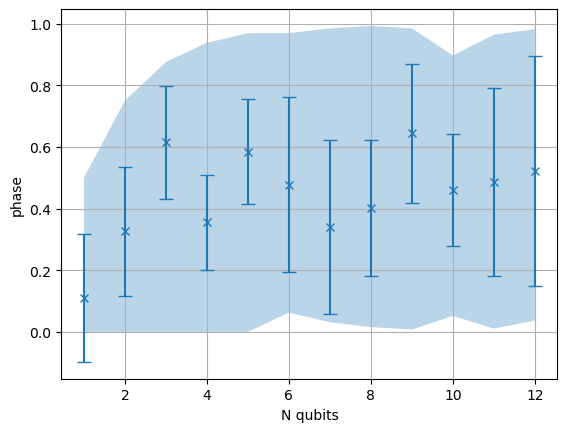

In [107]:
import matplotlib.pyplot as plt
values = np.array([np.array(phase(n, shots=1024)) for n in range(1, 13)])
print(values.shape)
plt.errorbar(range(1, 13), values.mean(axis=1), yerr=values.std(axis=1), capsize=5, linestyle="none", marker="x")
plt.fill_between(range(1, 13), values.min(axis=1), values.max(axis=1), alpha=0.3)
plt.grid()
plt.xlabel("N qubits")
plt.ylabel("phase")
plt.show()

This is not the desired result, but no time to find the error
